# Introduction - Sentiment Analysis using IMDB Dataset and Keras

For our Neural Networks example, let´s explore the IMDB reviews dataset, and try to come up with a sentiment analysis model. The idea is to train a model to be able to classify if a review has either a negative or positive sentiment.

We will use the Keras library running on top of Tensorflow. [link to more details on Keras](https://keras.io/)

# Import and declare helper functions

Initializations - import libraries

In [31]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pickle
from keras.utils.data_utils import get_file
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.2.4 backend: tensorflow


In [32]:
def decode_review(review):
    return ' '.join(id_to_word[id] for id in review)

In [33]:
def encode_review(review):
    review_split = review.lower().split(' ')
    encoded_review = []
  
    for word in review_split:
        try:
            encoded_review.append(word_to_id[word])
        except:
            encoded_review.append(word_to_id["<UNK>"])
            return encoded_review

In [34]:
def clean_text(text):  
    text = re.sub('[^A-Za-z0-9]+', ' ',text)
    return text

# Load the data

Keras already comes with the IMDB dataset built-in, all we got to do is download it using the imdb.load_data function

In [35]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data()
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

Loading data...
x_train: (25000,)
x_test: (25000,)


Every entry in the dataset is comprised of a review and a label, where:

*   reviews labeled 0 have a negative sentiment
*   reviews labeled 1 have a positive sentiment


In [36]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Looks like the dataset already comes encoded, so let´s create a dictionary mapping every token to its respective word, and another dictionary mapping every word to its token:

In [37]:
INDEX_FROM=3   # word index offset
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}

Now we have two dictionaries that we can use to both encode and decode any review (word to token, and vice versa).

Snippets of these dictionaries:

**word_to_id:**

'fawn': 34704,

 'tsukino': 52009,
 
 'nunnery': 52010,
 
 'sonja': 16819,
 
 'vani': 63954,
 
 'woods': 1411,
 
 'spiders': 16118....
 

** id_to_word:**
 
{34704: 'fawn', 

52009: 'tsukino', 

52010: 'nunnery',

16819: 'sonja',

63954: 'vani', 

1411: 'woods', 

16118: 'spiders',.....
 

Let´s print the first review in the training set (both the full text and encoded), plus its label:

In [38]:
print("First review in the training set:\n", decode_review(x_train[0]))

First review in the training set:
 <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but

In [39]:
print("First review in the training set (encoded):\n", x_train[0])

First review in the training set (encoded):
 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 

In [40]:
print("And its class/sentiment:\n", y_train[0])

And its class/sentiment:
 1


As we have reviews with different lengths (word count), we need to make sure all reviews have the same length before inputting them into the model. For that, we will use a technique called **padding**, which essentially will trim any review bigger than "maxlen" words (in our case, 100 words), plus pad any review with less than "maxlen" words with zeroes.

In [41]:
maxlen = 100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


# Build our model

In [42]:
embedding_dims = 200
lstm_units = 64
num_labels = 2

model = Sequential()
model.add(Embedding(len(id_to_word),
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))
model.add(LSTM(lstm_units))
model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Let´s explain how we build our model, layer by layer:



1.   ***model = Sequential()***

Explanation: there are two ways to build a model in Keras: using either the Sequential or Functional APIs. For this example, we will use the Sequential one. [Link to article with more details on their differences](https://jovianlin.io/keras-models-sequential-vs-functional/)
2.   ***model.add(Embedding(len(id_to_word), embedding_dims, input_length=maxlen))***

Explanation: Our first layer will be an Embedding layer. This layer will create a vector with size=embedding_dims (in our case, 200) for every word in the review, and the model will adjust the values of these vectors as it trains. At the end, every word will be represented by a vector, where similar words in context will have similar values in these vectors. Another way to describe the Embedding Layer is that it helps the model learn the intrisic properties of the features. [Link to articles with more details about Embedding layers](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

3. ***model.add(Dropout(0.2))***

Explanation: The Dropout layer is solely used to help avoiding overfitting. Overfitting can be described as having the model learn "too much" from the training data, thus it will not be able to generalize and make predictions based on previously unseen data. The Dropout layer helps by randomly dropping a small % of data as it learns

4. ***model.add(LSTM(lstm_units))***

Explanation: Here we add a LSTM layer, which is usually recommended when working with text. The lstm_units refers to the size of the LSTM hidden layer, where usually a bigger dimension will help the model learn more about the data (up to a point, and in the cost of memory and processing power).

5. ***model.add(Dense(num_labels, activation='softmax'))***

Explanation: And finally, we add a simple Dense Layer that will calculate the probability for every label (in our case, 2 labels). By using the softmax activation, we are basically telling the model to "shrink" the sum of all probabilities to 1

6. ***model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',  metrics=['accuracy'])***
              
 Explanation: Now that the model is built, we just compile it using this line of code.



In [43]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          17717400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 17,785,370
Trainable params: 17,785,370
Non-trainable params: 0
_________________________________________________________________
None


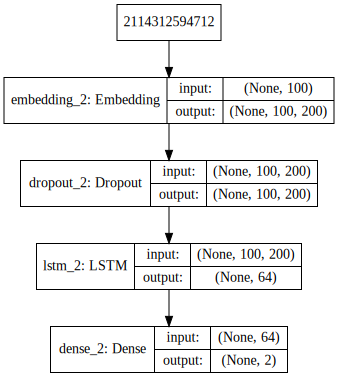

In [44]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

Let´s train our model now!

In [45]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=512,
          epochs=epochs, 
          validation_split=validation_split)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 61s 3ms/step - loss: 0.5721 - acc: 0.7013 - val_loss: 0.3948 - val_acc: 0.8294
Epoch 2/5
20000/20000 [==============================] - 60s 3ms/step - loss: 0.2744 - acc: 0.8889 - val_loss: 0.3490 - val_acc: 0.8510
Epoch 3/5
20000/20000 [==============================] - 71s 4ms/step - loss: 0.1385 - acc: 0.9528 - val_loss: 0.3657 - val_acc: 0.8420
Epoch 4/5
20000/20000 [==============================] - 71s 4ms/step - loss: 0.0860 - acc: 0.9733 - val_loss: 0.4314 - val_acc: 0.8376
Epoch 5/5
20000/20000 [==============================] - 73s 4ms/step - loss: 0.0566 - acc: 0.9831 - val_loss: 0.5621 - val_acc: 0.8354
Wall time: 5min 37s


# Model evaluation

Let´s now use the test data to calculate our model´s accuracy for unseen data.

In [46]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 82.64%


# Prediction

Great! Now let´s run some predictions. Given that everyone is talking about Game of Thrones these days, I copied two real reviews from IMDB for it. Let´s see what our model have to say about these reviews:

In [47]:
new_review = "What can be said that hasn't already been said about this show? Quite frankly, \
it's the greatest TV series ever created. Movie quality acting, set design, storytelling, cinematography, costumes....\
the one knock is in some of the early episodes CGI not being up to par (dragons mostly).\
The show is brilliant in almost every way. Never before have I been as surprised by the \
outcome and been along for an unpredictable ride of what happens and what is to come.\
My previous all time favorite show was Breaking Bad and there's a wide gap between GOT and pretty much anything else already out there. The word epic is thrown around too often these days as are 10's for anything that's halfway decent. GOT is as worthy as anything else being labeled as epic and deserves a 10 in an imperfect grading system."
new_review_cleaned = clean_text(new_review)
new_review_encoded = encode_review(new_review_cleaned)
new_review_encoded = sequence.pad_sequences([new_review_encoded], maxlen=maxlen)
model.predict(new_review_encoded)

array([[0.01169755, 0.9883024 ]], dtype=float32)

In [48]:
new_review = "This show started with promise, as I'm a huge Sean Bean and medieval fan... \
but with an absolutely nauseating amount of gratuitous and unnecessary sex and gore, \
my opinion turned sour very quickly. I don't consider myself high brow, but the violence in this show \
for the most part is geared towards a simple-minded audience...which I'm not a grunting ape \
so I necessitate more than that. Oh and lest I forget, I could overlook a bunch of the raunchy scenes \
if not for the unbelievably irritating character of Joffrey. That little puke completely ruins this show \
as I get so annoyed every time he's on screen that I grit my teeth and can't even watch. \
By the 7th episode, I was done and sent back my unopened second season to Amazon.Sorry I wasted my time."

new_review_cleaned = clean_text(new_review)
new_review_encoded = encode_review(new_review_cleaned)
new_review_encoded = sequence.pad_sequences([new_review_encoded], maxlen=maxlen)
model.predict(new_review_encoded)

array([[0.9923288, 0.0076712]], dtype=float32)